In [10]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import KBinsDiscretizer
from copy import  copy
import networkx as nx
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from pgmpy.estimators import HillClimbSearch
from pgmpy.estimators import BDeuScore, K2Score, BicScore
from pgmpy.models import BayesianModel
from pgmpy.sampling import BayesianModelSampling
from pgmpy.inference import VariableElimination
from pgmpy.base import DAG
from seaborn import distributions

### rain		Bool
### temp       	Air Temperature 	                                      °C
### wetb		Wet Bulb Air Temperature			                °C
### dewpt		Dew Point Air Temperature					°C
### vappr		Vapour Pressure							hpa
### rhum		Relative Humidity						%
### msl		Mean Sea Level Pressure						hPa
### wdsp		Mean Hourly Wind Speed						kt


### Target: temp, wetb, dewpt

In [2]:
df = pd.read_csv('../Data/clear_df.csv')
df = df.sample(frac=1).reset_index(drop=True)
df.head()

,latitude,longitude,rain,temp,wetb,dewpt,vappr,rhum,msl,wdsp
0,52.164,-8.264,0.0,2.7,2.6,2.3,7.2,97.0,999.1,1.0
1,53.306,-6.439,0.0,10.5,9.1,7.6,10.4,82.0,1002.3,33.0
2,53.326,-9.901,0.0,12.0,10.4,8.7,11.3,80.0,1026.2,10.0
3,53.906,-8.817,0.0,2.8,2.5,2.0,7.1,95.0,989.4,4.0
4,53.727,-7.981,0.0,2.2,1.2,-0.5,5.9,82.0,1016.8,10.0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4214711 entries, 0 to 4214710
Data columns (total 10 columns):
 #   Column     Dtype  
---  ------     -----  
 0   latitude   float64
 1   longitude  float64
 2   rain       float64
 3   temp       float64
 4   wetb       float64
 5   dewpt      float64
 6   vappr      float64
 7   rhum       float64
 8   msl        float64
 9   wdsp       float64
dtypes: float64(10)
memory usage: 321.6 MB


In [5]:
variables_name = ['latitude','longitude','rain', 'vappr', 'rhum', 'msl', 'wdsp']
variables = df[variables_name]
targets_name = ['temp', 'wetb', 'dewpt']
targets = df[targets_name]

### Sampling

In [7]:
bins = distributions._freedman_diaconis_bins(targets['temp'].values)
hist, bin_eges = np.histogram(targets['temp'].values, density=True)

In [12]:
bins = distributions._freedman_diaconis_bins(targets['temp'].values)
bins

598

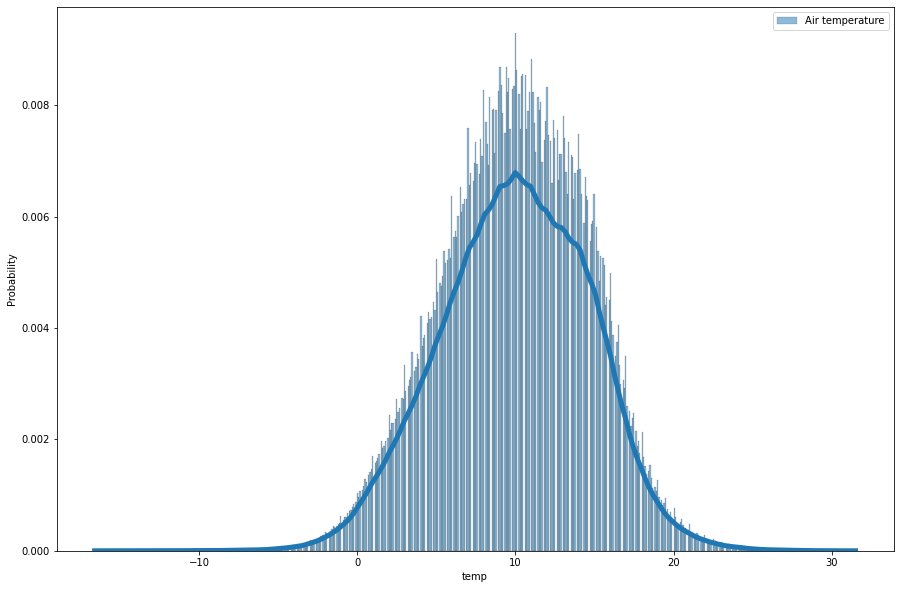

In [50]:
plt.figure(figsize=(15, 10))
sns.histplot(df['temp'], stat='probability', kde=True, label="Air temperature", line_kws={"linewidth":5, 'color':'r'})
plt.legend()
plt.show()

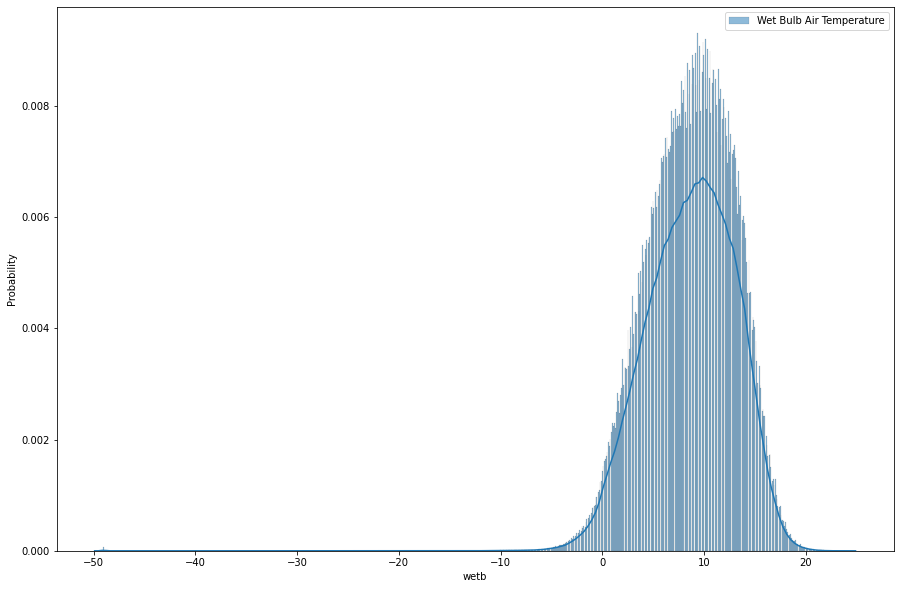

In [39]:
plt.figure(figsize=(15, 10))
sns.histplot(df['wetb'], stat='probability', kde=True, label="Wet Bulb Air Temperature")
plt.legend()

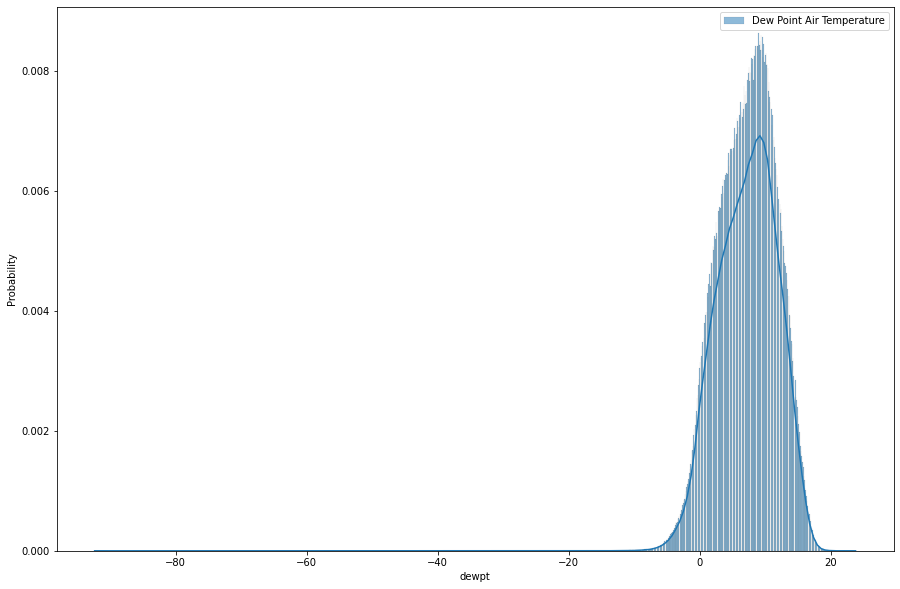

In [40]:
plt.figure(figsize=(15, 10))
sns.histplot(df['dewpt'], stat='probability', kde=True, label="Dew Point Air Temperature")
plt.legend()

In [4]:
hc = HillClimbSearch(df.head(50000), BicScore(df.head(50000)))

In [5]:
best_model = hc.estimate()

  0%|          | 0/1000000 [00:00<?, ?it/s]

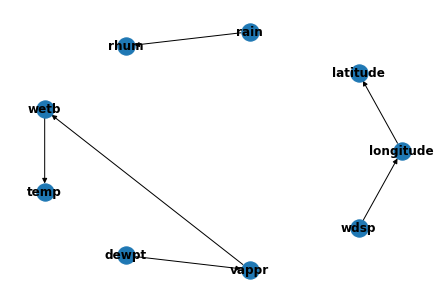

In [6]:
G_K2 = nx.DiGraph()
G_K2.add_edges_from(best_model.edges())
pos = nx.layout.circular_layout(G_K2)
nx.draw(G_K2, pos, with_labels=True,font_weight='bold')

In [12]:
def accuracy_params_restoration(bn: BayesianModel, data: pd.DataFrame):
    bn.fit(data)
    result = pd.DataFrame(columns=['Parameter', 'accuracy'])
    bn_infer = VariableElimination(bn)
    for j, param in enumerate(data.columns):
        accuracy = 0
        test_param = data[param]
        test_data = data.drop(columns=param)
        evidence = test_data.to_dict('records')
        predicted_param = []
        for element in evidence:
            prediction = bn_infer.map_query(variables=[param], evidence=element)
            predicted_param.append(prediction[param])
        accuracy = accuracy_score(test_param.values, predicted_param)
        result.loc[j,'Parameter'] = param
        result.loc[j, 'accuracy'] = accuracy
    return result

In [ ]:
accuracy_k2 = accuracy_params_restoration(BayesianModel(best_model.edges()), df.head(100000).drop('msl', axis=1))